# Cypher disstracks Analysis

Until know, we used multiple tools to get/clean/persist our data. It's now time to analyze it and find the answers to our questions.
The first step is to import our modules and load our graphs. There are two ways to get the graph because the networkx plot uses the neo4j GraphDatabase, but neo4jupyter uses the py2neo Graph and it's easier to use.

NB: If you want to rerun it directly from here, assuming the docker-compose (and mor specifically the neo4j service) is running, change the host from "neo4j" to "localhost"

In [ ]:
from py2neo import Graph
from neo4j import GraphDatabase
import networkx as nx
import matplotlib.pyplot as plt
import neo4jupyter

neo_host = "localhost"
neo_port = 7687

graph = Graph(f"bolt://{neo_host}:{neo_port}")
driver = GraphDatabase.driver(f"bolt://{neo_host}:{neo_port}")

## Questions

### Most dissed people

Our first question was to find who had the more disstracks realeased against him. We'll plot a bar plot to visualize it:

In [ ]:
NB_SELECTED = 10

graph.run("""MATCH ()-[r:Dissed]->(target)
                RETURN target.name, count(r) AS num
                ORDER BY num DESC
                LIMIT $nb_selected
            """, parameters={"nb_selected": NB_SELECTED}).to_data_frame().plot.bar(x='target.name', y='num')

### Most actives dissors

Our second question was to find who issued more disstracks. We'll once again plot a bar plot to visualize it:

In [ ]:
NB_SELECTED = 10

graph.run("""MATCH (artist)-[r:Dissed]->()
                RETURN artist.name, count(r) AS num
                ORDER BY num DESC
                LIMIT $nb_selected
            """, parameters={"nb_selected": NB_SELECTED}).to_data_frame().plot.bar(x='artist.name', y='num')

## Additionnal visualizations

It's great to have our answers but we want to visualize our data directly. Here's a plot representing the disses between the artists.
The plot just under is good looking and clear but may not render well on your machine. It's due to problems with the vis js lib as it wasn't meant to run from docker containers (that's what I understood from my research but it's just my conclusion as I didn't find any clear answer). There will be a second less good looking graph at the end to make up for it.

NB: To visualize it, what works for me is to restart the kernel ans rerun the notebook (not forgetting to change the host from neo4j to localhost)

In [ ]:
neo4jupyter.init_notebook_mode()
neo4jupyter.draw(graph, options={"Artist": "name", "Target": "name"})

# If you want to plot parts of the graph

#sub_g = graph.run("""
#    MATCH (artist)-[r:Dissed]->(target)
#    RETURN *""").to_subgraph()
#neo4jupyter.draw_subgraph(sub_g, options={"artist": "wikidata_id", "target": "name"})

Our last graph is that one. As you can see, it's not quite clean so it's only used as a substitute when the upper one can't be rendered.

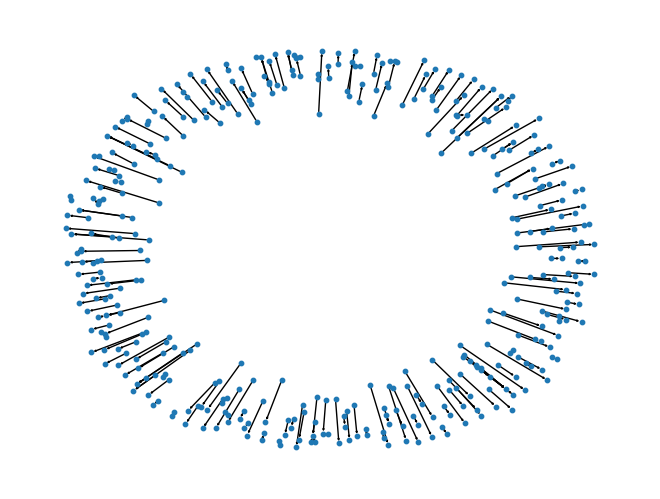

In [14]:
%matplotlib inline

results = driver.session().run("""
MATCH (n)-[r]->(c) RETURN *
""")

G = nx.MultiDiGraph()

for node in results.graph()._nodes.values():
    G.add_node(node.id, labels=node._labels, properties=node._properties)

rels = list(results.graph()._relationships.values())
for rel in rels:
    G.add_edge(rel.start_node.id, rel.end_node.id, key=rel.id, type=rel.type, properties=rel._properties)

nx.draw(G, node_size=10, arrowsize=2)
plt.show()